# **Exploring the BraTS Challenge Dataset**

In this notebook, we will delve into the **[MSD Task01_BrainTumor Dataset](http://medicaldecathlon.com/index.html)**. This dataset is one of the well-known datasets for brain tumor segmentation tasks containing complex and heterogeneously-located targets and is stored in the compressed NIfTI format (`.nii.gz`).

## **Understanding the NIfTI Format**

The NIfTI format is widely used in the field of neuroimaging. Unlike its predecessor, the Analyze format—which consists of two separate files: a header file (`.hdr`) that stores meta-information and an image file (`.img`) that contains the actual data—the NIfTI format consolidates both the header and image data into a single file with a `.nii` extension.

### **Why Compression Matters in Medical Imaging**

Medical images, such as CT and MRI scans, are known for their large file sizes due to the high level of detail they must retain. However, a significant portion of these images often consists of solid background with minimal informational content. This makes them excellent candidates for compression.

NIfTI files can be compressed using the deflate algorithm (commonly used by gzip), which allows for efficient on-the-fly compression and decompression. The compressed versions of these files are saved with the `.gz` extension appended, resulting in files with the `.nii.gz` format. For a deeper understanding of the NIfTI file format, you can refer to this [resource](https://brainder.org/2012/09/23/the-nifti-file-format/).

## **Objectives of This Notebook**

In this notebook, we will:

1. **Understand Data Formats:** Gain familiarity with the NIfTI file format, commonly used for storing medical imaging data, and explore its structure and content.
2. **Explore MSD Task01 Dataset Structure:** Investigate the organization of the dataset, including the roles of training images, segmentation labels, and test images, to understand the data we will work with.
3. **Visualize Medical Images:** Visualize the image data from various acquisition planes and explore different MRI sequences to gain insights into the brain tumor's characteristics.
4. **Analyze Label Distribution:** Examine and quantify the distribution of different labels within the segmentation masks, focusing on the regions of interest, such as tumor and non-tumor areas.

## **Set up environment**
As the first step, we will set up our environment by installing necessary libraries.


In [ ]:
#!pip install -r requirements.txt # This is intended for the local use of the notebook

Let's import libraries that we will use in this notebook.

In [ ]:
import os
from glob import glob

import google.colab.drive as drive
import nibabel as nib
import numpy as np
from ipywidgets import interact,fixed
import matplotlib.pyplot as plt
from matplotlib import colors

from skimage.transform import rotate
from skimage.util import montage
%matplotlib inline

## **Download the MSD Task_01 BrainTumor Dataset**

The **MSD Task_01 BrainTumor dataset** consists of 750 multiparametric magnetic resonance images (mp-MRI) from patients diagnosed with either glioblastoma or lower-grade glioma. The sequences used were native T1-weighted (T1), post-Gadolinium (Gd) contrast T1-weighted (T1-Gd), native T2-weighted (T2), and T2 Fluid-Attenuated Inversion Recovery (FLAIR). The corresponding target ROIs were the three tumor sub-regions, namely edema, enhancing, and non-enhancing tumor.

This dataset was selected due to the challenge of locating these complex and heterogeneously-located targets. The data was acquired from 19 different institutions and contained a subset of the data used in the 2016 and 2017 Brain Tumor Segmentation (BraTS) challenges[1].

To download the dataset, we access the Medical Segmentation Decathlon (MSD) [website](http://medicaldecathlon.com/index.html), where they offer two options for downloading: either directly from AWS or by accessing the data hosted on Google Drive. In this notebook, we'll proceed with the Google Drive option since we are working in the Google Colab environment. To facilitate this, we create a shortcut to the dataset in our Google Drive.

Then, we mount the drive in Colab:   

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Next, we extract the contents of the tar file, which contains the dataset files. The following command is used to extract the tar file:

In [ ]:
!tar -xvf "/content/drive/MyDrive/Task01_BrainTumour.tar"

## **Data Loading**

The **Task01_BrainTumour** dataset directory is organized to facilitate the process of training and testing models for brain tumor segmentation. The directory is structured as follows:

- **`Task01_BrainTumour/`**: This is the main directory containing all the data files for the brain tumor segmentation task.

  - **`imagesTr/`**: This subdirectory contains the training images. Each file in this folder represents an mp-MRI scan, which is used as input data for training segmentation models.

  - **`labelsTr/`**: This subdirectory contains the corresponding labels for the training images. Each file here provides the ground truth segmentation masks that indicate the location and boundaries of brain tumors within the mp-MRI scans.

  - **`imagesTs/`**: This subdirectory contains the test images. These files are mp-MRI scans similar to those in the `imagesTr` folder, but they do not have corresponding labels. These images are used to evaluate the performance of trained models by predicting tumor locations without access to ground truth labels.

  After downloading the dataset, let's explore a sample to examine the information it contains.

As a first step, we will examine a sample patient from our dataset. We will load both the MRI images and the corresponding segmentation mask created by an expert radiologist.

Each image in the dataset represents a 3D volume acquired using four different MRI sequences, listed as follows: FLAIR, T1, T1-Gd (T1 with Gadolinium contrast), and T2.

These four modalities highlight different aspects of the brain tissue, providing complementary information for the same region.

### **Description of the MRI Sequences:**

- **T1-weighted (T1):** This sequence is used to visualize the structure and composition of different types of tissue in the brain. It helps in identifying tumors, cysts, and other abnormalities.

- **Post-contrast T1-weighted (T1-Gd or T1ce):** Similar to T1-weighted images, but with the injection of a contrast agent (Gadolinium). The contrast enhances the visibility of abnormalities, making them more distinguishable.

- **T2-weighted (T2):** This sequence is used to show the fluid content within different types of brain tissue, which is helpful for detecting edema and other fluid-related abnormalities.

- **T2-FLAIR (Fluid-Attenuated Inversion Recovery):** This sequence suppresses the signal from fluids, such as cerebrospinal fluid, to better visualize lesions. It is particularly useful for identifying lesions in the white matter of the brain that may not be clearly visible on T1 or T2 images.

In [ ]:
# Specify a sample and segmentation path (here we will take the first patient of the Training dataset)
sample_img_path = '/content/Task01_BrainTumour/imagesTr/BRATS_001.nii.gz'
sample_seg_path = '/content/Task01_BrainTumour/labelsTr/BRATS_001.nii.gz'

# Load the sample image and label located in the image and label paths using the nibabel library
sample_img = nib.load(sample_img_path)
sample_seg = nib.load(sample_seg_path)

Let's take a look at the metadata contained within the header of the NIfTI image sample. The same applies to the segmentation mask. The metadata is stored in the header, which follows the NIfTI-1 format, a compact C structure of 348 bytes. This header includes the following fields:

In [ ]:
print('Image Header:\n', sample_img.header)

Image Header:
 <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4 240 240 155   4   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.10'
aux_file        : b'none'
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x          : [1. 0. 0. 

For more detailed information on the significance of these fields, you can refer to this [link](https://brainder.org/2012/09/23/the-nifti-file-format/).

The next step is to examine the actual data within the NIfTI file. To do this, we'll use the `.get_fdata()` method. But before diving into the data, let’s first take a look at the image's shape.



In [ ]:
print("Image's Shape:", sample_img.shape)
print("Mask's Shape:", sample_seg.shape)

Image's Shape: (240, 240, 155, 4)
Mask's Shape: (240, 240, 155)


As you can see, the image shape is a 4D array. Let’s break down what this means:

- **Spatial Dimensions (3D):** The first three dimensions represent the spatial dimensions of the MRI scan, these correspond to the width, height, and depth of the brain in the scan. This gives us a 3D volume of the brain, which can be viewed in different planes:
  - **Axial or Transverse Plane:** Horizontal slices from top to bottom also referred to as a "head-toe" plane.
  - **Coronal or Frontal Plane:** Vertical slices from front to back also known as a "side-side" plane.
  - **Sagittal Plane:** Vertical slices from left to right also known as a "front-back" plane.

- **Modality Dimension (4th Dimension):** The fourth dimension represents the different MRI sequences or modalities captured for the scan. These modalities provide complementary views of the brain:
  - **FLAIR (Fluid-Attenuated Inversion Recovery):** Suppresses fluid signals to highlight lesions.
  - **T1-weighted (T1):** Shows the structure and composition of brain tissues.
  - **T1-Gd (T1 with Gadolinium contrast):** Enhances the visibility of abnormalities by using a contrast agent.
  - **T2-weighted (T2):** Highlights fluid content in the brain tissue.

Understanding these dimensions allows us to interpret the data better and visualize the brain structures from various perspectives and modalities.

However, the segmentation mask shape is a 3D array that contains the spatial dimensions, as described for the MRI image.

To gain a better understanding of what we've described above, let's visualize these images, starting with the modalities and the segmentation mask:

In [ ]:
# Get the image data
img_data = sample_img.get_fdata()
seg_data = sample_seg.get_fdata()

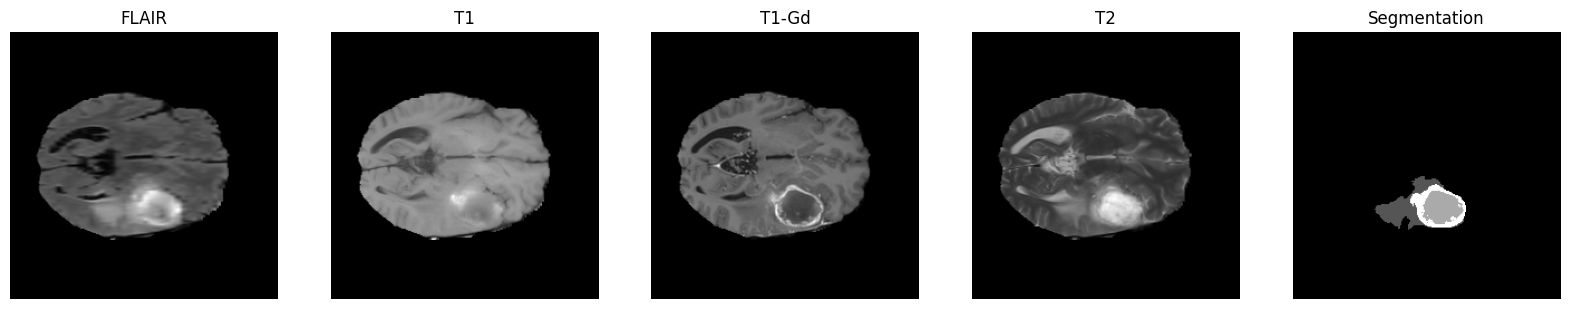

In [ ]:
# Plot the 70th slice of the 4 RMI modalities and the segmentation mask
slice_nb = 70

fig, axs = plt.subplots(1, 5, figsize=(20,20))
axs[0].imshow(img_data[:,:,slice_nb,0], cmap="gray")
axs[0].set_title('FLAIR')
axs[0].axis('off')

axs[1].imshow(img_data[:,:,slice_nb,1], cmap="gray")
axs[1].set_title('T1')
axs[1].axis('off')

axs[2].imshow(img_data[:,:,slice_nb,2], cmap="gray")
axs[2].set_title('T1-Gd')
axs[2].axis('off')

axs[3].imshow(img_data[:,:,slice_nb,3], cmap="gray")
axs[3].set_title('T2')
axs[3].axis('off')

axs[4].imshow(seg_data[:,:,slice_nb], cmap="gray")
axs[4].set_title('Segmentation')
axs[4].axis('off')
plt.show()

Now, let's move on to see the MRI scan and the segmentation mask from different plans:

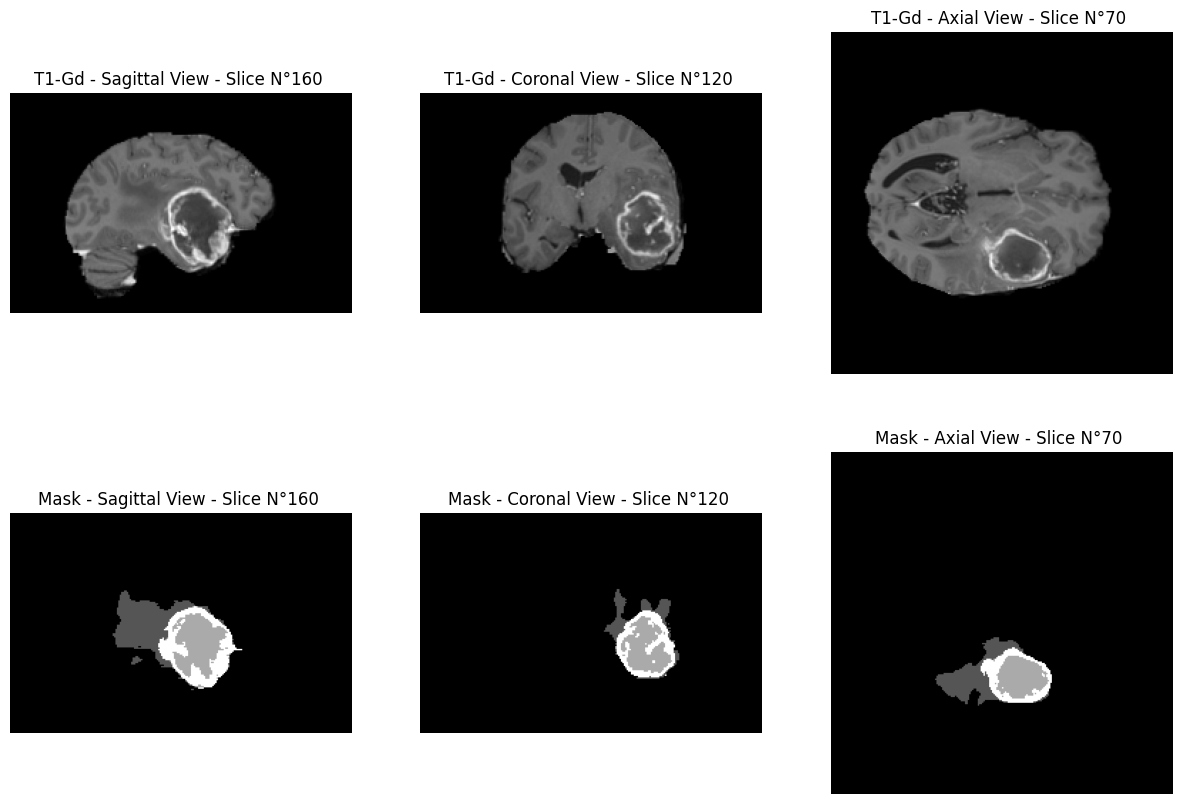

In [ ]:
slice_nb_axial = 70
slice_nb_coronal = 120
slice_nb_sagittal = 160

# Create a 2x3 grid for displaying the MRI images and corresponding masks
fig, axs1 = plt.subplots(2, 3, figsize=(15, 10))

# Display the MRI modality (T1-Gd) images in the top row
axs1[0, 0].imshow(rotate(img_data[slice_nb_sagittal,:,:,2], 90, resize=True), cmap="gray")
axs1[0, 0].set_title('T1-Gd - Sagittal View - Slice N°{} '.format(slice_nb_sagittal))
axs1[0, 0].axis('off')

axs1[0, 1].imshow(rotate(img_data[:,slice_nb_coronal,:,2], 90, resize=True), cmap="gray")
axs1[0, 1].set_title('T1-Gd - Coronal View - Slice N°{} '.format(slice_nb_coronal))
axs1[0, 1].axis('off')

axs1[0, 2].imshow(img_data[:,:,slice_nb_axial,2], cmap="gray")
axs1[0, 2].set_title('T1-Gd - Axial View - Slice N°{} '.format(slice_nb_axial))
axs1[0, 2].axis('off')

# Display the corresponding segmentation masks in the bottom row
axs1[1, 0].imshow(rotate(seg_data[slice_nb_sagittal,:,:], 90, resize=True), cmap="gray")
axs1[1, 0].set_title('Mask - Sagittal View - Slice N°{} '.format(slice_nb_sagittal))
axs1[1, 0].axis('off')

axs1[1, 1].imshow(rotate(seg_data[:,slice_nb_coronal,:], 90, resize=True), cmap="gray")
axs1[1, 1].set_title('Mask - Coronal View - Slice N°{} '.format(slice_nb_coronal))
axs1[1, 1].axis('off')

axs1[1, 2].imshow(seg_data[:,:,slice_nb_axial], cmap="gray")
axs1[1, 2].set_title('Mask - Axial View - Slice N°{} '.format(slice_nb_axial))
axs1[1, 2].axis('off')

plt.show()

## **Interactive Data Exploration with `IPyWidgets`**

In this section, we will explore the MRI data in an interactive manner using `ipywidgets`. This approach allows us to navigate through different 2D slices within the 3D volume and switch between various modalities with ease.

Instead of creating three separate functions to visualize a specific acquisition plane, we have developed a single function that includes an argument called `plane`, allowing you to choose which plane you would like to visualize.

Using interactive sliders, we can seamlessly scroll through the slices, gaining deeper insights into the spatial structure and variations of the brain structures and tumor regions across across the different MRI sequences.

This hands-on method not only enhances our understanding of the spatial relationships within the data but also helps in identifying the unique features captured by each MRI sequence.

In [ ]:
# Define a function to visualize 3D MRI data in different planes
def explore_4dimage(layer, MRI_Seq, input_data, plane='axial'):
    """
    Visualizes a single layer of the 3D MRI volume in the specified plane (axial, sagittal, or coronal).

    Args:
        layer (int): The index of the slice to visualize.
        MRI_Seq (int): The MRI modality to visualize (e.g., FLAIR, T1ce, T2).
        input_data (numpy array): 4D MRI volume data (x, y, z, modalities).
        plane (str): The plane of visualization ('axial', 'sagittal', 'coronal').
    """
    plt.figure(figsize=(10, 5))

    if plane == 'axial':
        # Visualize axial plane (default)
        plt.imshow(input_data[:, :, layer, MRI_Seq], cmap='gray')
        plt.title(f'Axial Plane - Layer {layer}', fontsize=16)

    elif plane == 'sagittal':
        # Visualize sagittal plane
        plt.imshow(rotate(input_data[layer,:,:, MRI_Seq], 90, resize=True), cmap="gray")
        plt.title(f'Sagittal Plane - Layer {layer}', fontsize=16)

    elif plane == 'coronal':
        # Visualize coronal plane
        plt.imshow(rotate(input_data[:, layer, :,MRI_Seq], 90, resize=True), cmap='gray')
        plt.title(f'Coronal Plane - Layer {layer}', fontsize=16)

    else:
        raise ValueError("Invalid plane argument. Choose 'axial', 'sagittal', or 'coronal'.")

    plt.axis('off')
    plt.show()

In [ ]:
# Run the ipywidgets interact() function to explore the data in the axial plane
interact(explore_4dimage, layer=(0,img_data.shape[2]-1), MRI_Seq=(0,img_data.shape[3]-1), input_data=fixed(img_data), plane='axial')

interactive(children=(IntSlider(value=77, description='layer', max=154), IntSlider(value=1, description='MRI_S…

<function __main__.explore_4dimage(layer, MRI_Seq, input_data, plane='axial')>

**Note:** A visualization issue—specifically update flickering—arose during the use of `ipywidgets` in Google Colab. This problem is discussed in the following StackOverflow post: [Ipywidgets interact function in Google Colab creates new plots instead of updating the desired plots](https://stackoverflow.com/questions/76079118/ipywidgets-interact-function-in-google-colab-creates-new-plots-instead-of-updati).

To resolve this issue, simply add `plt.show()` at the end of your plotting function. This issue is specific to Google Colab and doesn't occur when running the notebook locally on adequate hardware.

For further details and examples, a valuable notebook is shared in the discussion. You can access it [here](https://colab.research.google.com/github/jupyter-widgets/ipywidgets/blob/master/docs/source/examples/Using%20Interact.ipynb).

In [ ]:
# Run the ipywidgets interact() function to explore the data in the sagittal plane
interact(explore_4dimage, layer=(0,img_data.shape[0]-1), MRI_Seq=(0,img_data.shape[3]-1), input_data=fixed(img_data), plane='sagittal')

interactive(children=(IntSlider(value=119, description='layer', max=239), IntSlider(value=1, description='MRI_…

<function __main__.explore_4dimage(layer, MRI_Seq, input_data, plane='axial')>

In [ ]:
# Run the ipywidgets interact() function to explore the data in the coronal plane
interact(explore_4dimage, layer=(0,img_data.shape[1]-1), MRI_Seq=(0,img_data.shape[3]-1), input_data=fixed(img_data), plane='coronal')

interactive(children=(IntSlider(value=119, description='layer', max=239), IntSlider(value=1, description='MRI_…

<function __main__.explore_4dimage(layer, MRI_Seq, input_data, plane='axial')>

### **Scan Exploration with `Skimage` Montage**

In this section, we will delve into another method for examining MRI scans: using the `montage` function from the `scikit-image` library.

The `montage` function allows us to create a composite image by arranging multiple 2D slices from the 3D MRI volume into a single, grid-like visualization. This approach provides a comprehensive view of the scan, making it easier to spot patterns and the overall structure of the brain across multiple slices at once.

It is particularly useful when trying to get a quick overview of the entire volume. This method complements the interactive exploration tools by providing a static, yet highly informative, perspective on the data.

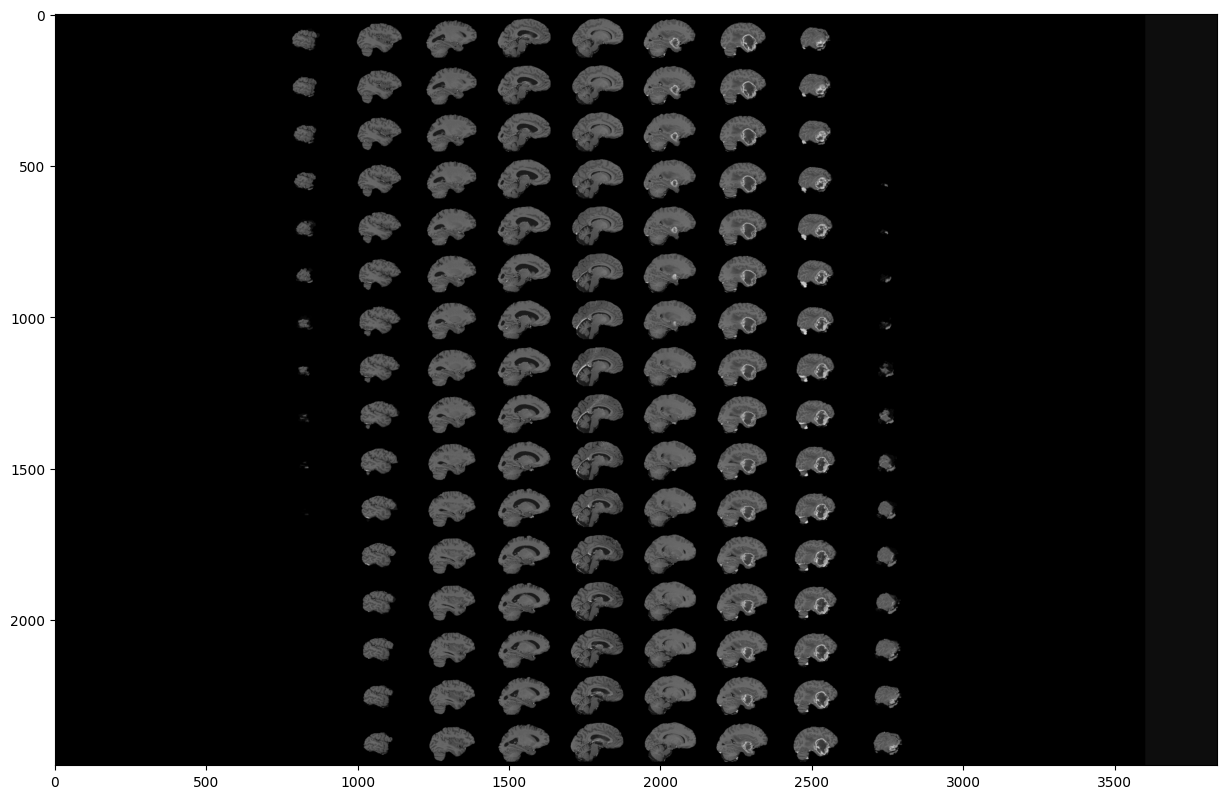

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(img_data[:,:,:,2]), 90, resize=True), cmap ='gray')
#ax1.axis('off')
# montage allows us to concatenate multiple images of the same size horizontally and vertically

In the resulting visualization, you may notice that several of the first and last slices in the volume appear completely black. This indicates that these slices do not contain any relevant information about the brain, as they are positioned outside the region of interest.

A practical decision moving forward would be to exclude these non-informative slices from the dataset used for training a deep learning model in the segmentation task.

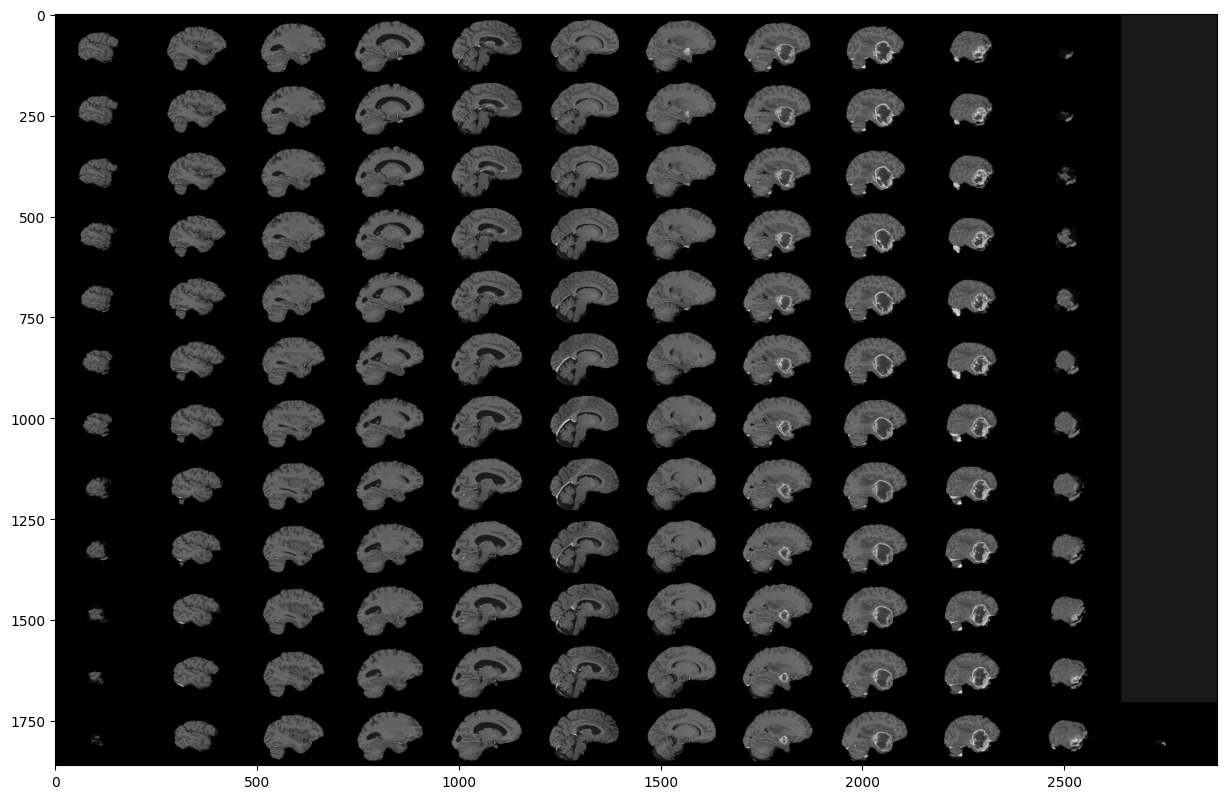

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(img_data[55:188,:,:,2]), 90, resize=True), cmap ='gray')

By removing these empty slices, we can achieve several key benefits:

1. **Memory and Storage Efficiency:** By eliminating these empty slices, we can significantly reduce the size of the volumes stored in memory and on disk. This is particularly beneficial given the constraints of our hardware, as it allows us to load larger batches during training.

2. **Faster Training:** Reducing the number of slices per volume also decreases the overall amount of data the model needs to process, leading to shorter training times. This efficiency gain is crucial when working with large datasets or limited computational resources.

3. **Focused Learning:** By training the model only on slices containing relevant anatomical information, we ensure that the model focuses on learning meaningful patterns, which can potentially improve its performance on the segmentation task.



### **Manual Annotations and Label Interpretation**

The dataset has been meticulously annotated by one to four raters, following a standardized annotation protocol. Each annotation has been reviewed and approved by experienced neuro-radiologists, ensuring high-quality, accurate labeling.

The annotations include the following regions:

- **GD-enhancing tumor (ET — label 3):** This label represents the part of the tumor that shows enhancement after the injection of a gadolinium-based contrast agent, indicating active tumor regions.
- **Peritumoral edematous/invaded tissue (ED — label 2):** This label identifies the surrounding tissue that has been affected by the tumor, including areas of edema or invasion.
- **Necrotic tumor core (NCR — label 1):** This label marks the dead or necrotic core of the tumor, which typically appears darker on the scans.
- **Non-tumor region (NT — label 0):** This label represents areas of the brain that are not affected by the tumor, essentially the healthy brain tissue and the blank background.

Each of these labels can be visually distinguished in the segmentation mask, depending on the color map used to plot the volume. The color map helps in identifying and differentiating between these labels, making it easier to interpret the annotated regions. The visual distinction is crucial for understanding the spatial relationships between the different components of the tumor and the surrounding tissues, as shown below:

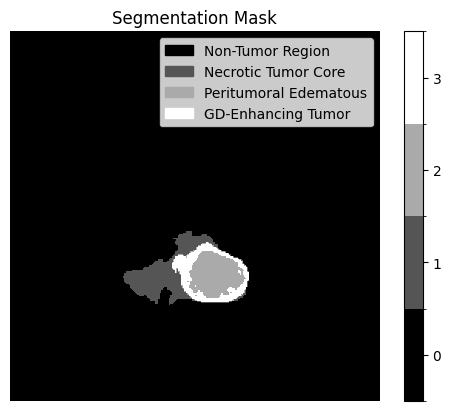

In [ ]:
cmap = plt.cm.gray
norm = colors.BoundaryNorm(np.arange(-0.5, 4, 1), cmap.N)
class_names = ['Non-Tumor Region', 'Necrotic Tumor Core', 'Peritumoral Edematous', 'GD-Enhancing Tumor']
legend = [plt.Rectangle((0, 0), 1, 1, color=plt.cm.ScalarMappable(norm=norm, cmap=cmap).to_rgba(i), label=class_names[i]) for i in range(len(class_names))]

plt.imshow(seg_data[:,:,70], cmap=cmap, norm=norm)
plt.title('Segmentation Mask')
plt.legend(handles=legend, loc='upper right')
plt.colorbar(ticks=np.linspace(-1, 3, 5))
plt.axis('off')
plt.show()

### **Analysis of Labels Distribution in the Segmentation Mask**

Let’s examine different slices from the sample volume to understand how each region is represented by its assigned label values.

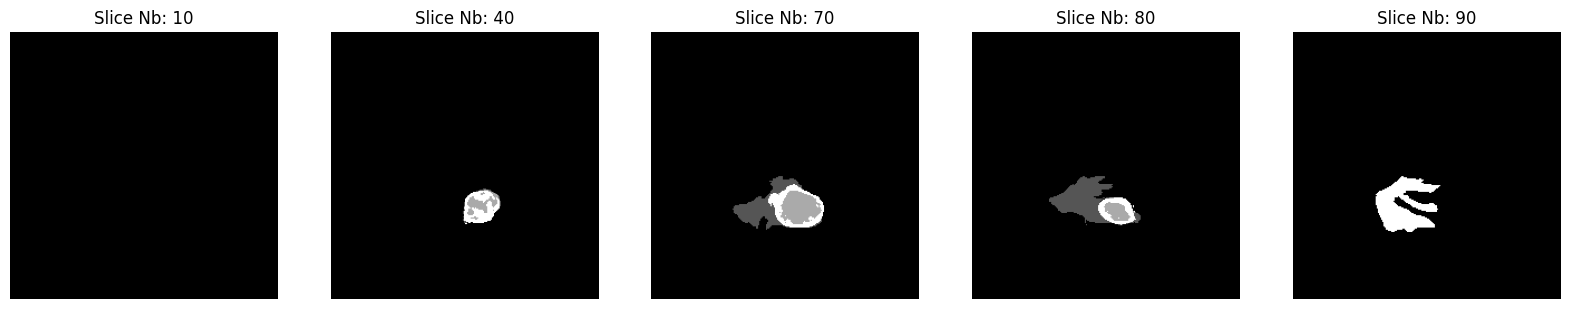

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(20,20))

axs[0].imshow(seg_data[:,:,10], cmap="gray")
axs[0].set_title('Slice Nb: 10')
axs[0].axis('off')

axs[1].imshow(seg_data[:,:,40], cmap="gray")
axs[1].set_title('Slice Nb: 40')
axs[1].axis('off')

axs[2].imshow(seg_data[:,:,70], cmap="gray")
axs[2].set_title('Slice Nb: 70')
axs[2].axis('off')

axs[3].imshow(seg_data[:,:,80], cmap="gray")
axs[3].set_title('Slice Nb: 80')
axs[3].axis('off')

axs[4].imshow(seg_data[:,:,90], cmap="gray")
axs[4].set_title('Slice Nb: 90')
axs[4].axis('off')

plt.axis('off')
plt.show()

We can use the `montage` function to display the entire segmentation mask in a single view:

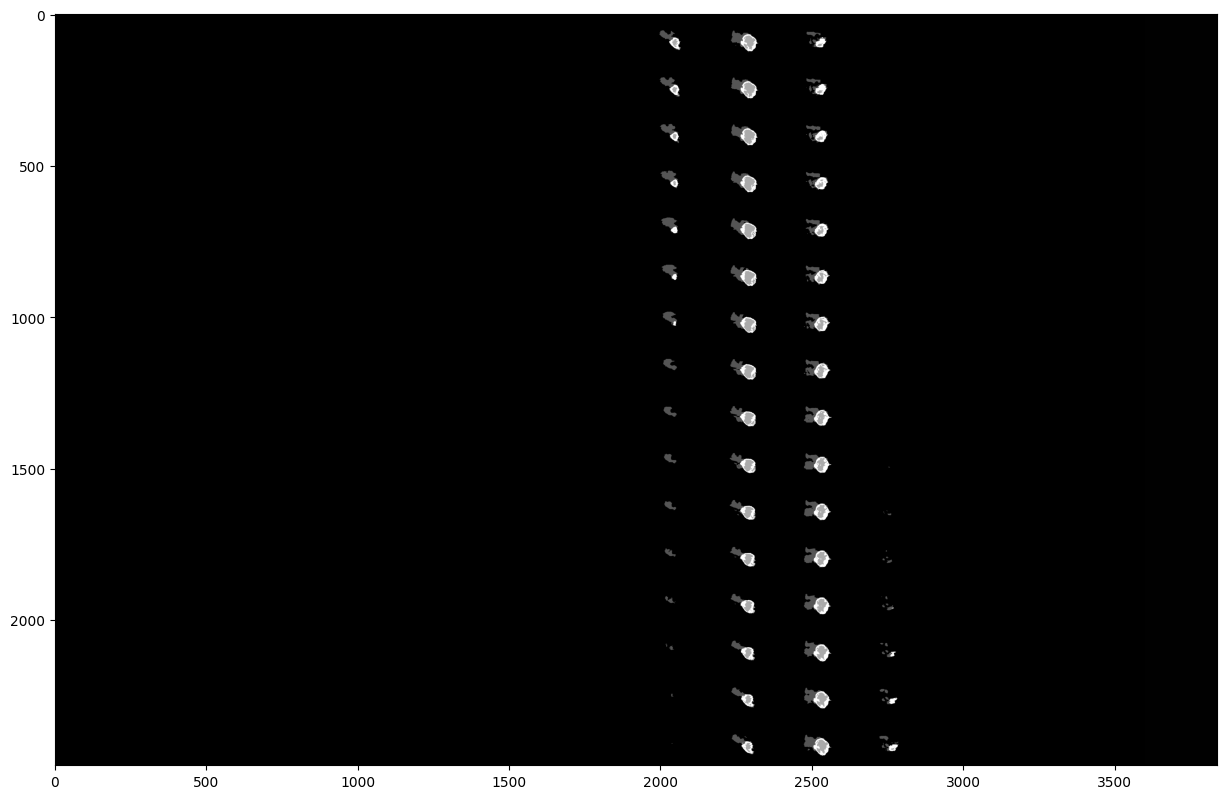

In [ ]:
# Display all slices of a segmentation
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(seg_data[:,:,:]), 90, resize=True), cmap ='gray')

Visually, it is evident that the zero values (representing the non-tumor region, NT) dominate the scans. This suggests that the tumor regions are relatively small compared to the healthy brain tissue. However, to confirm this observation, we should quantitatively analyze the distribution of these labels across the entire volume.

Before we proceed with that analysis, let’s first inspect the volumes within the dataset to ensure that only the expected label values—0, 1, 2, and 3—are present, and that no unexpected values have been assigned. This step is crucial for validating the integrity of the data and ensuring that our subsequent analysis accurately reflects the true composition of the tumor and non-tumor regions.

In [ ]:
seg_samples = sorted(glob("/content/Task01_BrainTumour/labelsTr/BRATS_*.nii.gz"))
saved_values = []
max_nb_values = 0

for sample in seg_samples:
    seg_img = nib.load(sample).get_fdata()
    unique_values = np.unique(seg_img)
    nb_unique_values = len(np.unique(seg_img))

    if nb_unique_values > max_nb_values:
        max_nb_values = nb_unique_values
        saved_values = unique_values

print(f"Maximum number of values in all segmentation images: {max_nb_values}")
print(f"Values: {saved_values}")

Maximum number of values in all segmentation images: 4
Values: [0. 1. 2. 3.]
Values counts: []


To quantitatively demonstrate the significance of the non-tumor region, we will count the number of voxels assigned to each label in a sample segmentation mask. By analyzing the frequency of these values, we can gain a clearer understanding of how the different regions are distributed within the volume.

In [ ]:
values, counts = np.unique(seg_data, return_counts=True)
print(counts)

[8816276   53050   27189   31485]


This analysis confirms our visual observation that the non-tumor region is predominant and provides a concrete measure of the proportion of each class within the sample. Such insights are valuable for understanding the challenges of tumor segmentation. Let's visualize each class individually:

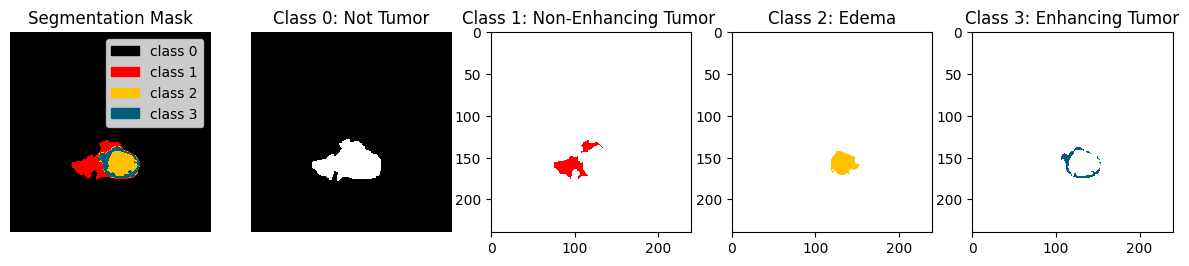

In [ ]:
cmap1 = colors.ListedColormap(['#000000','#FF0000', '#FFC100', '#035E7B'])
norm = colors.BoundaryNorm(np.arange(-0.5, 4, 1), cmap1.N)

# Isolation of class 0
# Deletion of class 0
seg_0 = seg_data.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = seg_data.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = seg_data.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_3 = seg_data.copy()
seg_3[seg_3 != 3] = np.nan

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 3']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap1(i), label=class_names[i]) for i in range(len(class_names))]

fig, axs3 = plt.subplots(1, 5, figsize=(15, 15))

axs3[0].imshow(seg_data[:,:,70], cmap=cmap1, norm=norm)
axs3[0].set_title('Segmentation Mask')
axs3[0].legend(handles=legend, loc='upper right')
axs3[0].axis('off')

axs3[1].imshow(seg_0[:,:,70], cmap=cmap1, norm=norm)
axs3[1].set_title('Class 0: Not Tumor')
axs3[1].axis('off')

axs3[2].imshow(seg_1[:,:,70], cmap=cmap1, norm=norm)
axs3[2].set_title('Class 1: Non-Enhancing Tumor ')
#axs3[2].axis('off')

axs3[3].imshow(seg_2[:,:,70], cmap=cmap1, norm=norm)
axs3[3].set_title('Class 2: Edema')
#axs3[3].axis('off')

axs3[4].imshow(seg_3[:,:,70], cmap=cmap1, norm=norm)
axs3[4].set_title('Class 3: Enhancing Tumor')
#axs3[4].axis('off')

plt.show()

# **Conclusion**

- We started by understanding the NIfTI file format used for storing MRI data, highlighting its advantages in terms of compression and storage efficiency.

- We examined the dataset structure, including the training images, segmentation labels, and test images, and discussed the significance of each.

- **Data Visualization:** We explored various methods to visualize our data, ranging from traditional techniques using Matplotlib to view individual slices and modalities, to interactive tools with IPyWidgets that allow for the exploration of MRI volumes across different planes and modalities. Additionally, we utilized the `skimage` montage function to display entire volumes, offering a comprehensive overview of the data.

  - **Optimization Considerations:** We discussed strategies for optimizing data processing, such as excluding non-informative slices, to improve memory usage, disk space, and training efficiency.

- We examined the annotations, understanding the different labels used for tumor regions and non-tumor regions, and quantified their distribution in the segmentation mask.


These steps have laid a strong foundation for understanding and processing the dataset, preparing us for the next steps.